## 1. Import Important Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.anova import anova_lm
from statsmodels.stats import weightstats as smw

### 2. Display Settings

In [2]:
pd.set_option('display.max_rows', 40)
pd.set_option('display.max_columns', 50)
plt.rcParams['figure.figsize'] = (8, 5)

### 3. Load and Clean The Data

In [3]:
df = pd.read_csv(
    r'C:\Users\Vishal jadhav\OneDrive\Desktop\cycling_cleaned.txt',
    sep=r'\s*(?=(?:[^"]*"[^"]*")*[^"]*$)\s',
    engine='python',
    quotechar='"',
    skipinitialspace=True
)

df.columns = ['rider', 'rider_class', 'stage', 'points', 'stage_class']

for c in ['rider', 'rider_class', 'stage', 'points', 'stage_class']:
    df[c] = df[c].astype(str).str.replace('"', '').str.strip()

df['points'] = pd.to_numeric(df['points'], errors='coerce')

print("Shape:", df.shape)
display(df.head(10))

Shape: (3496, 5)


,rider,rider_class,stage,points,stage_class
0,Tadej Pogačar,All Rounder,X1,15,flat
1,Tadej Pogačar,All Rounder,X2,219,hills
2,Tadej Pogačar,All Rounder,X3,34,flat
3,Tadej Pogačar,All Rounder,X4,264,hills
4,Tadej Pogačar,All Rounder,X6,114,hills
5,Tadej Pogačar,All Rounder,X7,274,hills
6,Tadej Pogačar,All Rounder,X8,50,flat
7,Tadej Pogačar,All Rounder,X9,50,flat
8,Tadej Pogačar,All Rounder,X10,109,hills
9,Tadej Pogačar,All Rounder,X11,39,hills


### 4. Overview

In [4]:
print(df.shape, 'riders:', df.rider.nunique(), 'stages:', df.stage.nunique())
print(df.groupby('rider_class')['points'].agg(['mean', 'std', 'count']))

(3496, 5) riders: 184 stages: 19
                  mean        std  count
rider_class                             
All Rounder  37.687307  63.961640    323
Climber      20.169336  43.447254    437
Sprinter     15.036298  41.832247    551
Unclassed     6.419680  23.282527   2185


### 5. Descriptive Plots

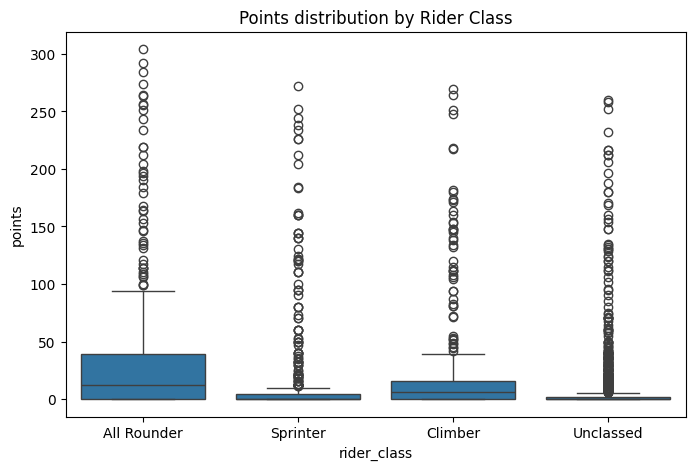

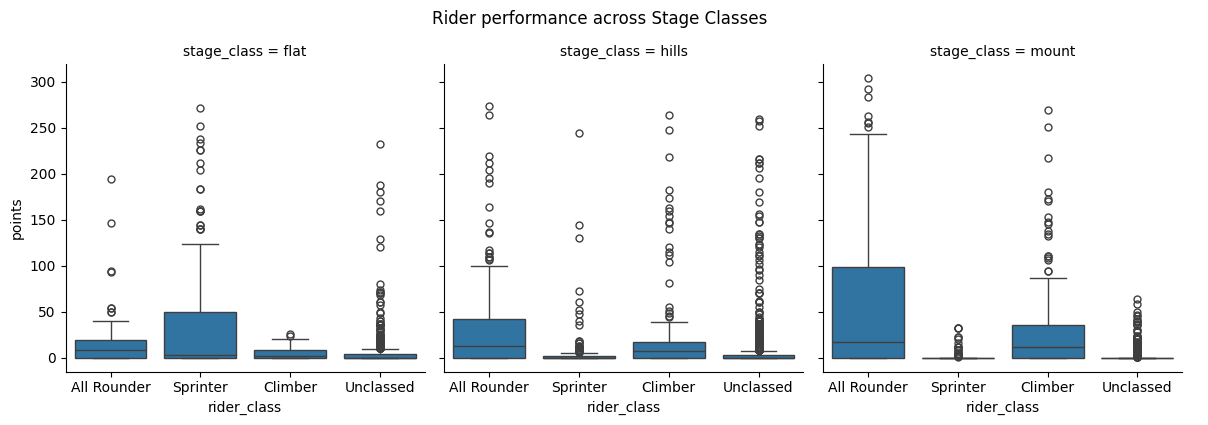

In [5]:
sns.boxplot(x='rider_class', y='points', data=df)
plt.title('Points distribution by Rider Class'); plt.show()

sns.catplot(x='rider_class', y='points', col='stage_class',
           data=df, kind='box', height=4)
plt.suptitle('Rider performance across Stage Classes', y=1.05)
plt.show()

### 6. Normality & Variance Checks

In [6]:
for c in df.rider_class.unique():
    s = df.loc[df.rider_class==c, 'points']
    print(c, 'Shapiro p=', stats.shapiro(s.sample(min(len(s), 500)))[1])

All Rounder Shapiro p= 1.6784199540468157e-25
Sprinter Shapiro p= 3.5884452533759447e-37
Climber Shapiro p= 2.9840365132460728e-33
Unclassed Shapiro p= 1.2933708129517423e-39


### 7. Classical Tests

In [7]:
# One-Way ANOVA (parametric)
aov = smf.ols('points ~ C(rider_class)', data=df).fit()
print('\nANOVA:\n', sm.stats.anova_lm(aov, typ=2))

# Kruskal-Wallis test (non-parametric)
print('\nKruskal-Wallis p=',
     stats.kruskal(*[df.loc[df.rider_class==c,'points'] for c in df.rider_class.unique()])[1])

# Tukey's HSD (pairwise group connection)
from statsmodels.stats.multicomp import pairwise_tukeyhsd
print('\nTukey HSD:\n', pairwise_tukeyhsd(df.points, df.rider_class))


ANOVA:
                       sum_sq      df          F        PR(>F)
C(rider_class)  3.148937e+05     3.0  85.505214  2.198409e-53
Residual        4.286712e+06  3492.0        NaN           NaN

Kruskal-Wallis p= 2.887179491172402e-71

Tukey HSD:
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1     group2  meandiff p-adj   lower    upper   reject
--------------------------------------------------------------
All Rounder   Climber  -17.518    0.0 -24.1259   -10.91   True
All Rounder  Sprinter  -22.651    0.0 -28.9618 -16.3402   True
All Rounder Unclassed -31.2676    0.0  -36.636 -25.8993   True
    Climber  Sprinter   -5.133 0.1012 -10.9016   0.6355  False
    Climber Unclassed -13.7497    0.0 -18.4687  -9.0306   True
   Sprinter Unclassed  -8.6166    0.0 -12.9096  -4.3236   True
--------------------------------------------------------------


### 8. Linear Mixed Effects Model

In [8]:
# Build the mixed model
model = smf.mixedlm("points ~ rider_class + stage_class", data=df, groups=df["rider"])

# Fit the model
result = model.fit()
print(result.summary())

                Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     points     
No. Observations:      3496        Method:                 REML       
No. Groups:            184         Scale:                  1017.2395  
Min. group size:       19          Log-Likelihood:         -17200.5603
Max. group size:       19          Converged:              Yes        
Mean group size:       19.0                                           
----------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------------------
Intercept                 37.096    4.054  9.150 0.000  29.150  45.043
rider_class[T.Climber]   -17.518    5.243 -3.341 0.001 -27.794  -7.242
rider_class[T.Sprinter]  -22.651    5.007 -4.524 0.000 -32.465 -12.837
rider_class[T.Unclassed] -31.268    4.260 -7.341 0.000 -39.616 -22.919
stage_class[T.hills]   

### 9. Rider-Level Variance : Intra-Class Correlation

In [9]:
# Calculate Intra-Class Correlation (ICC)
vr, ve = result.cov_re.iloc[0,0], result.scale
icc = vr / (vr + ve)
print(f"Rider-level variance: {vr:.3f}")
print(f"Residual variance: {ve:.3f}")
print(f"Intra-Class correlation (ICC): {icc:.3f}")

# Interpretation
print(f"\n≈ {icc*100:.1f}% of total variance in points is explained by differences between riders.")

Rider-level variance: 215.179
Residual variance: 1017.240
Intra-Class correlation (ICC): 0.175

≈ 17.5% of total variance in points is explained by differences between riders.


### 10. Residual Diagnostics

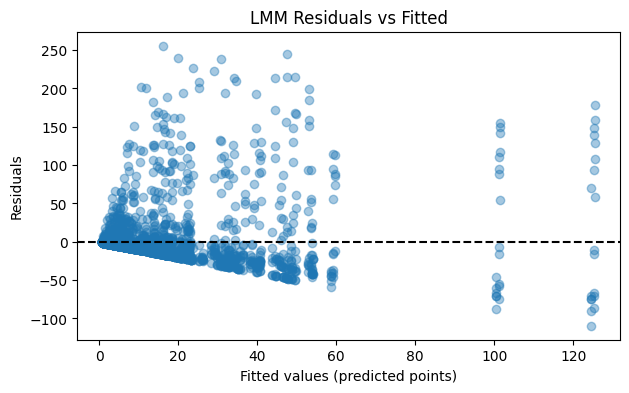

In [10]:
# Extract residuals and fitted values from your fitted model
resid = result.resid
fit = result.fittedvalues

# Residuals vs fitted plots
plt.figure(figsize=(7,4))
plt.scatter(fit, resid, alpha=0.4)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('Fitted values (predicted points)')
plt.ylabel('Residuals')
plt.title('LMM Residuals vs Fitted')
plt.show()

***With gratitude to the TU Dortmund University Admissions Committee for their time and consideration.***